In [1]:
import ira
from tqdm.notebook import tqdm
%alphalab dark

from c3p.models.utils import load_all_contracts_data, contracts_for, bitmex_contract_expiration
from alpha.utils.tick_loaders import load_data

Reloaded /usr/local/envs/ira_p36/lib/python3.6/site-packages/ira/experimental/c_simulator_core.pyx


Some helpers stuff

In [192]:
def prepare_data(underlying, conversion=None):
    ctrs = contracts_for(underlying)
    symbols = {f'BITMEXH:{x.name}' for x in ctrs} | {f'BITMEXH:{underlying}',}
    return mstruct(
        underlying = underlying, ctrs = ctrs, symbols=symbols, 
        data = load_data(*symbols),
        # ETH, LTC, EOS are nominated in BTC so we need to convert to USD
        conv_data = load_data(f'BITMEXH:{conversion}') if conversion else None,
        conv_symbol = conversion,
    )

def spread_abs(x, y):
    d = x - y
    return d - d.iloc[0]

def spread_pct(x, y):
    return x / y - 1

def spread_ret(x, y):
    dr = x.pct_change() - y.pct_change()
    dr[~np.isfinite(dr)] = 0
    return (1 + dr).cumprod() - 1

def plot_statistics(sx, spread_calculator=spread_abs):
    k = 1
    for i, c in enumerate(sx.ctrs, 1):
        data = sx.data[[c.name, sx.underlying]].ohlc('1h')
        if sx.conv_symbol:
            cdata = sx.conv_data.ohlc('1h')
            data = {**data, **cdata}
        
        xd = retain_columns_and_join(data, 'close').dropna()
        if not xd.empty:
            f = xd[c.name]
            if sx.conv_symbol:
                f = f * xd[sx.conv_symbol]
            u = xd[sx.underlying]
            dp = spread_calculator(f, u)
            
            yl = 1.01 * max(abs(dp))
            sbp(53, k); 
            k += 1 
            plt.fill_between(dp.index, -yl, 0, color='r', alpha=0.3)
            plt.fill_between(dp.index, +yl, 0, color='g', alpha=0.3)
            plt.plot(dp, label=c.name); plt.legend()
            plt.axhline(0, ls='--', c='g'); plt.ylim((-yl, yl))
    plt.suptitle(sx.underlying, fontsize=18)

Load data for coins we have perpetual swaps for (actually most traded ones)

In [182]:
d_xbt = prepare_data('XBTUSD')
d_eth = prepare_data('ETHUSD', 'XBTUSD')
d_ltc = prepare_data('LTCUSD', 'XBTUSD')
d_eos = prepare_data('EOSUSD', 'XBTUSD')

Now we will take a look at basis distance behaviour for every contract. 
Here basis at every moment of time t is defined as $B_t = F_t - U_t$.

where (F - futures price, U - underlying spot price (perpetual)). For first approximation we will use close prices for 5 Min timeframe.

if $B_t$ > 0 contract in contango (green area) and premium is high otherwise it's in backwardation (red area)

<hr/>

Other spread calculations ways:

1. $S_t = \frac{F_t}{U_t} - 1$


2. $S_t = \prod^t_{i=0}({1 + r(F_{i}) - r(U_{i}}))$, where $r(X_t) := \frac{X_t}{X_{t-1}} - 1$

<hr/>

<u>Main objectives of this research is to findout</u>

   - how often futures contract is in contango
   - does basis converge to 0 near expiration date

# <font color='yellow'>XBTUSD</font>

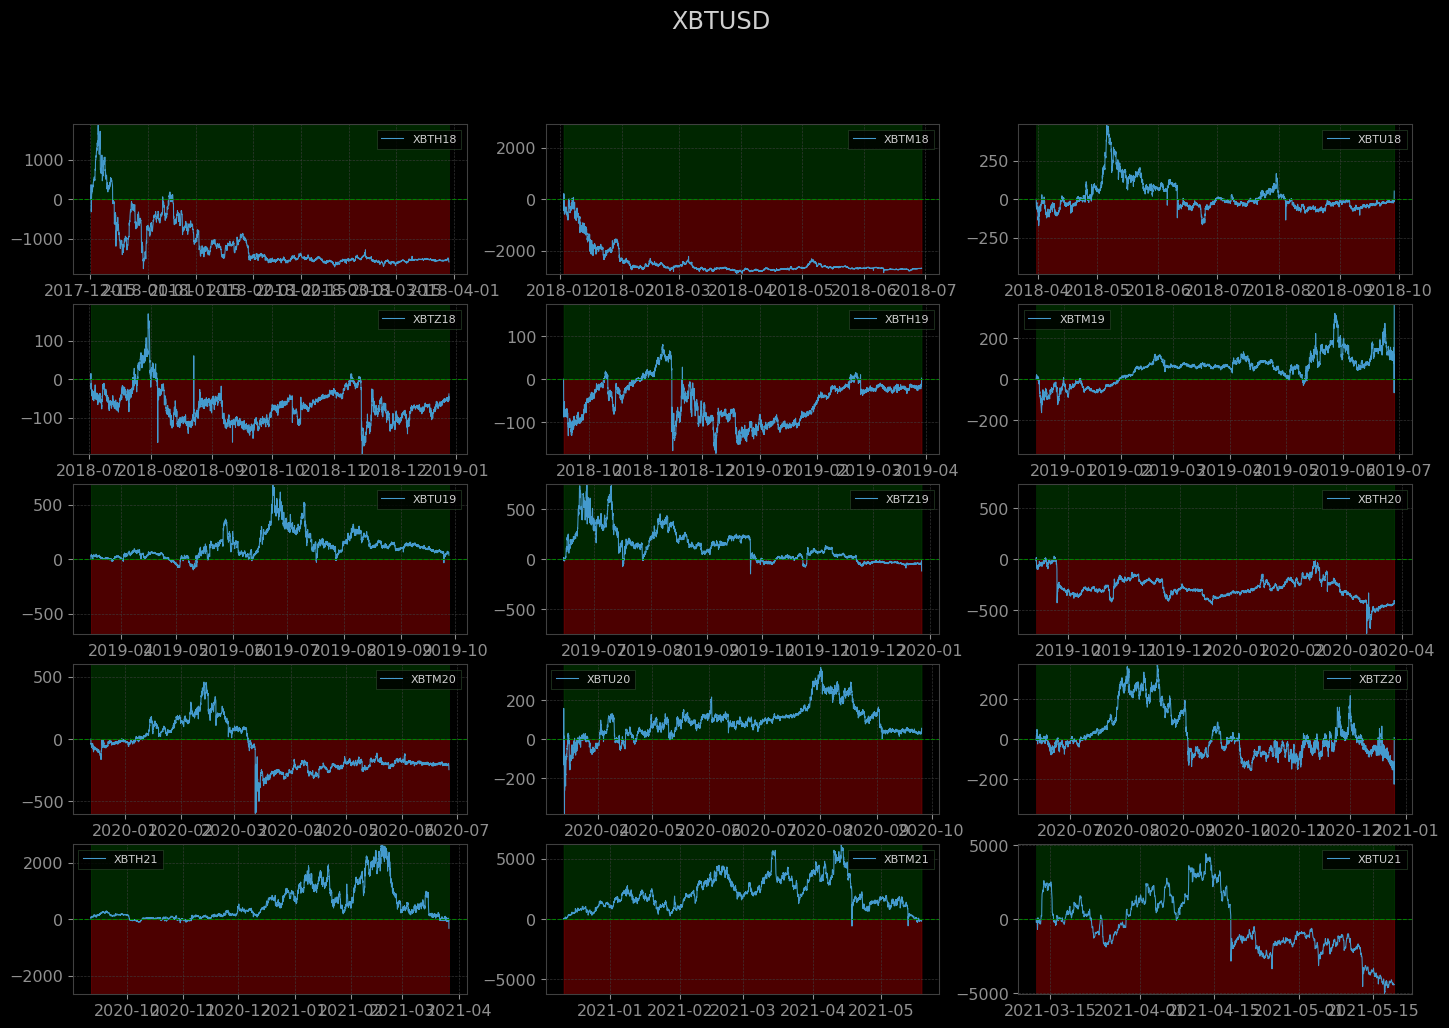

In [179]:
fig(18, 12); plot_statistics(d_xbt)

# <font color='yellow'>ETHUSD</font>

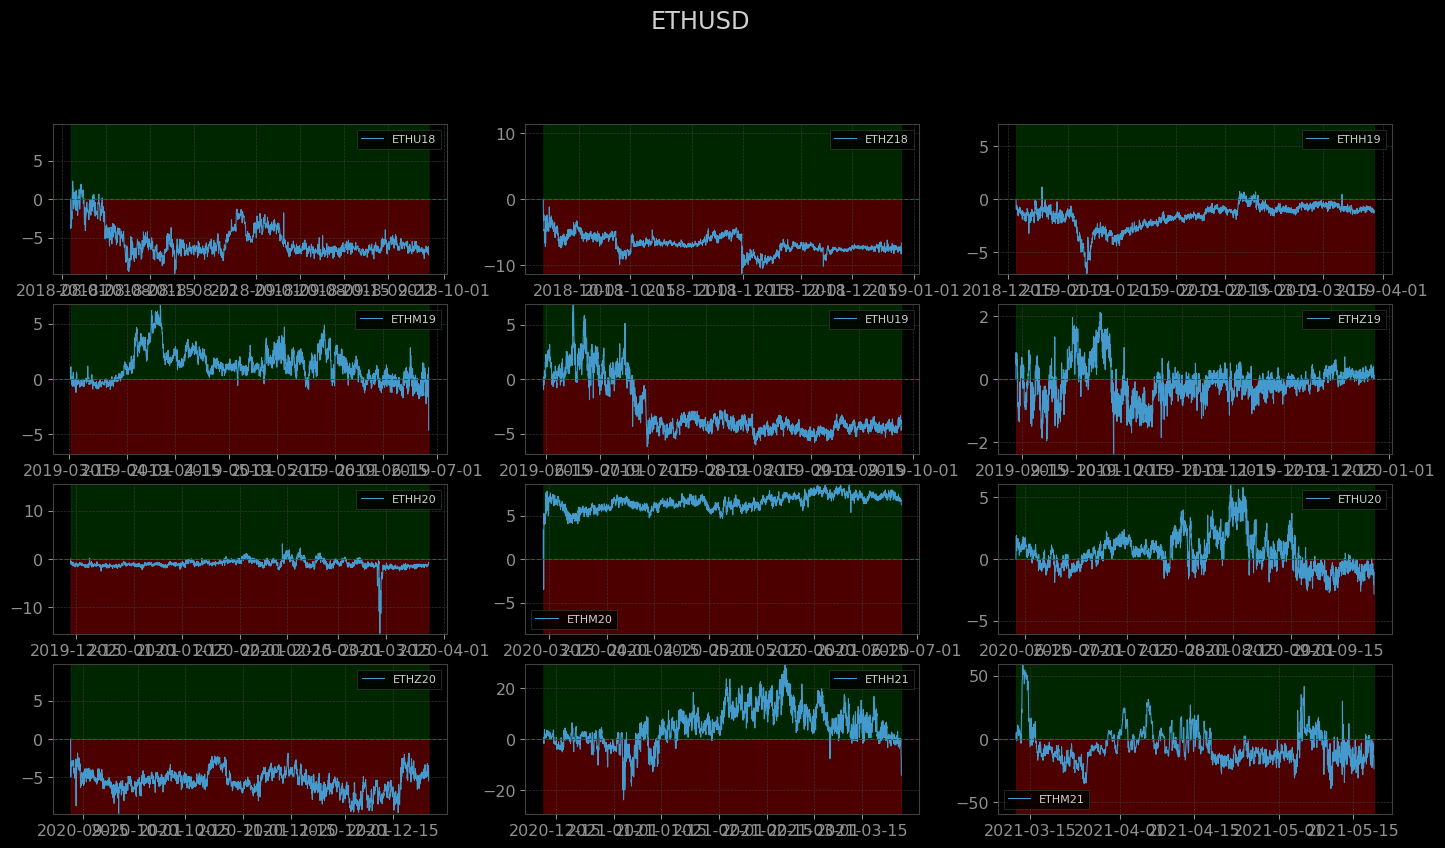

In [193]:
fig(18, 12); plot_statistics(d_eth)

# <font color='yellow'>LTCUSD</font>

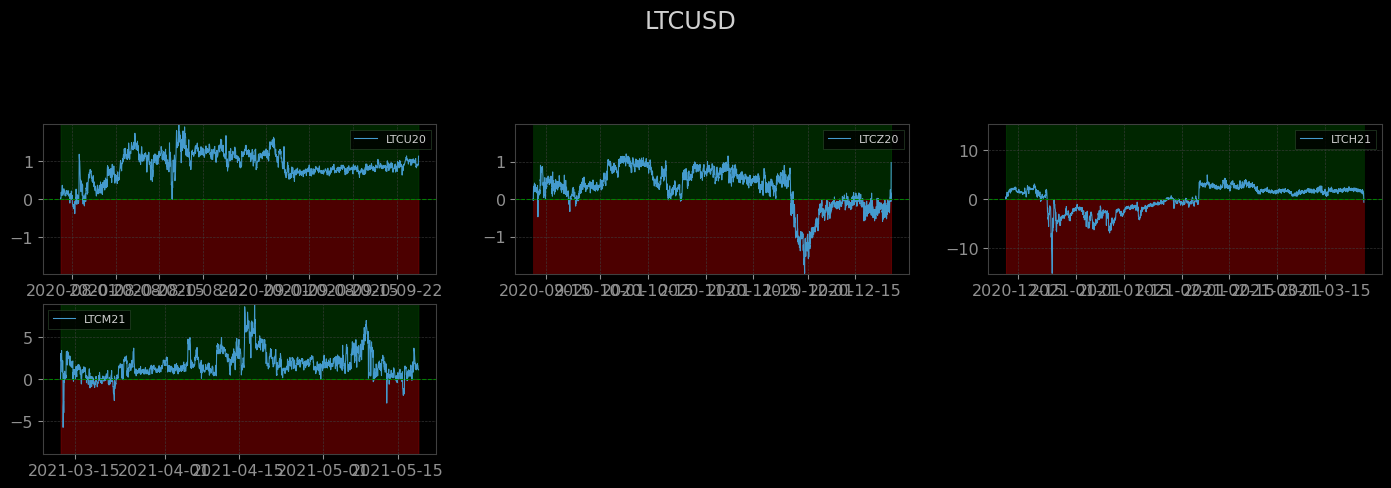

In [194]:
fig(18, 12); plot_statistics(d_ltc)

# <font color='yellow'>EOSUSD</font>

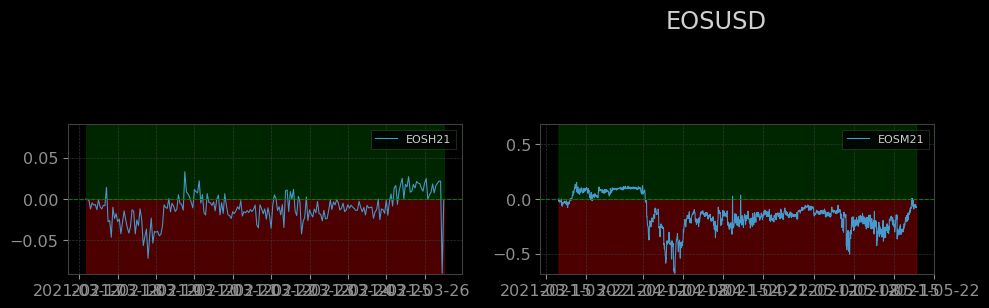

In [195]:
fig(18, 12); plot_statistics(d_eos)

# <font color='green'>Some first observations</font>
<hr/>

 - xbt futures likely to be more tradeable at least on BitMex from 'sell futures' model point of view
 
 - it's difficult to select some fixed threshold to used as entry point: we observed different spreads for basis for different contracts
    - we should use dynamic threshold based on current state of basis series
    
   
 
 - basis series demonstrates mean-reverting properties so we could try to trade not only "sell futures + buy underlying" model but also try reverted: ("buy future + short sell underlying perpetual") when basis is in backwardarion 
    - for this (full) model we could also trade other assets (LTC, ETH, EOS) which demonstrate negative premium recent times
 

<hr/>

# <font color='yellow'>XBTUSD (percentage spread)</font>

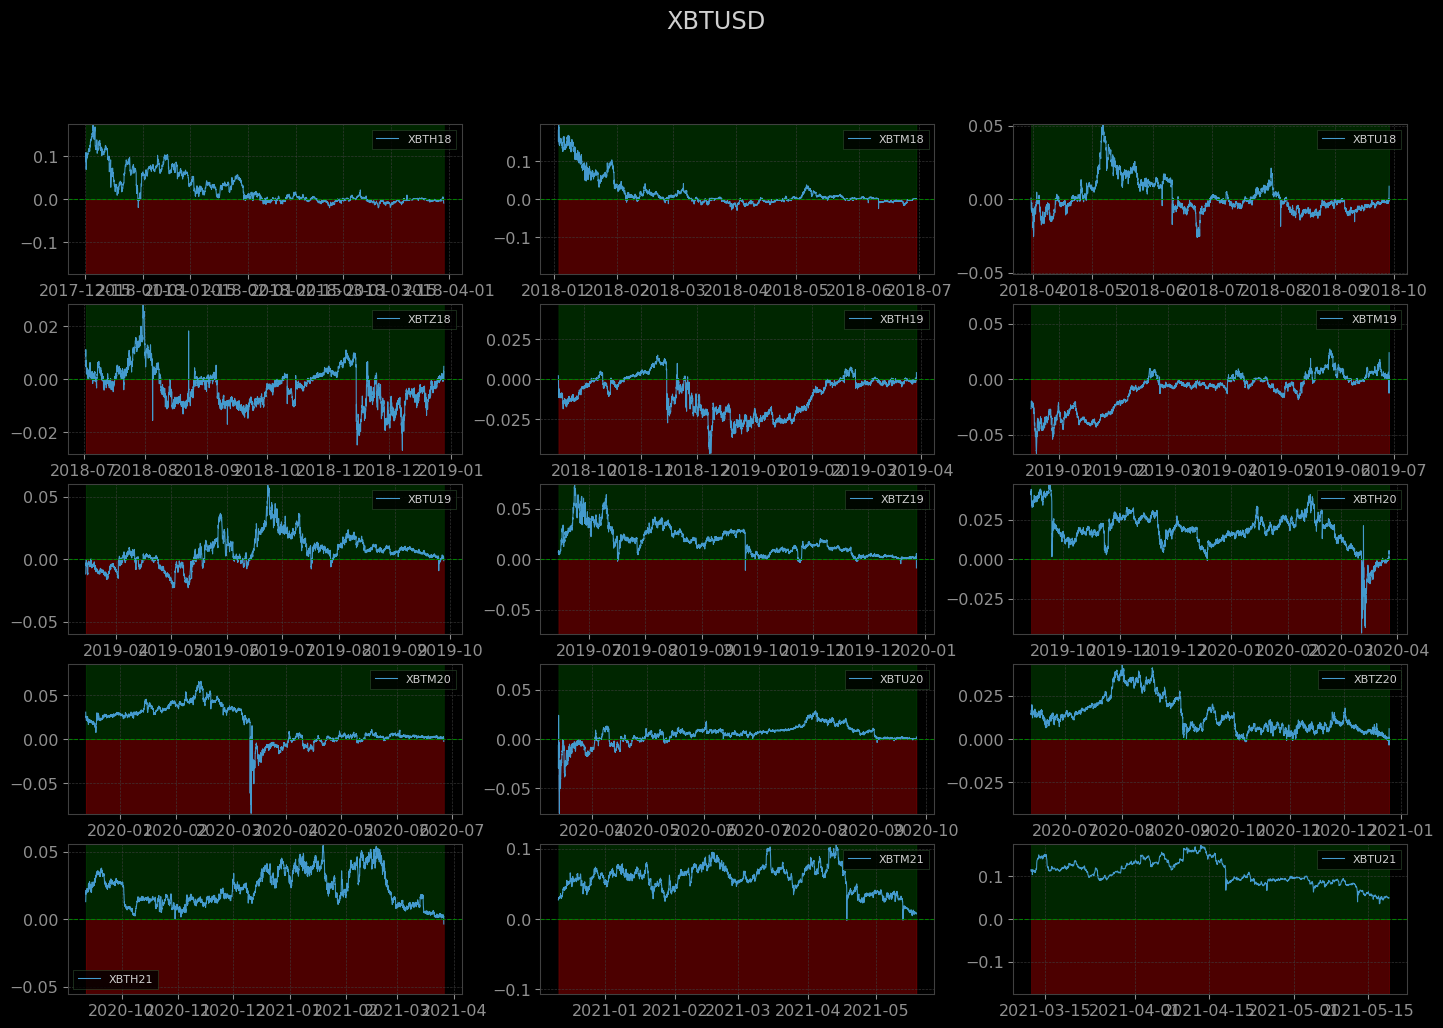

In [196]:
fig(18, 12); plot_statistics(d_xbt, spread_pct)

# <font color='yellow'>ETHUSD (percentage spread)</font>

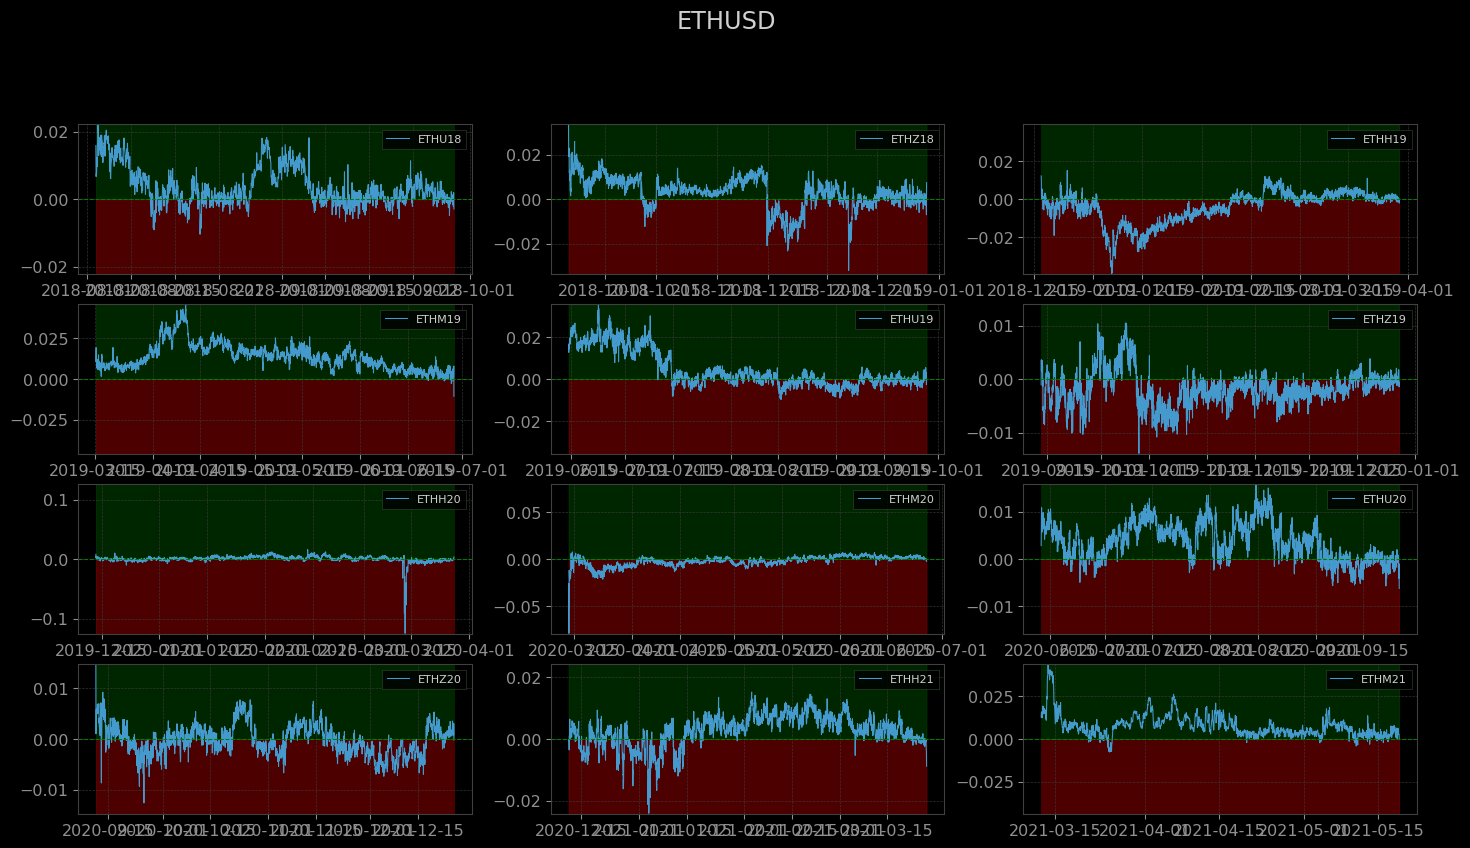

In [197]:
fig(18, 12); plot_statistics(d_eth, spread_pct)

# <font color='yellow'>LTCUSD (percentage spread)</font>

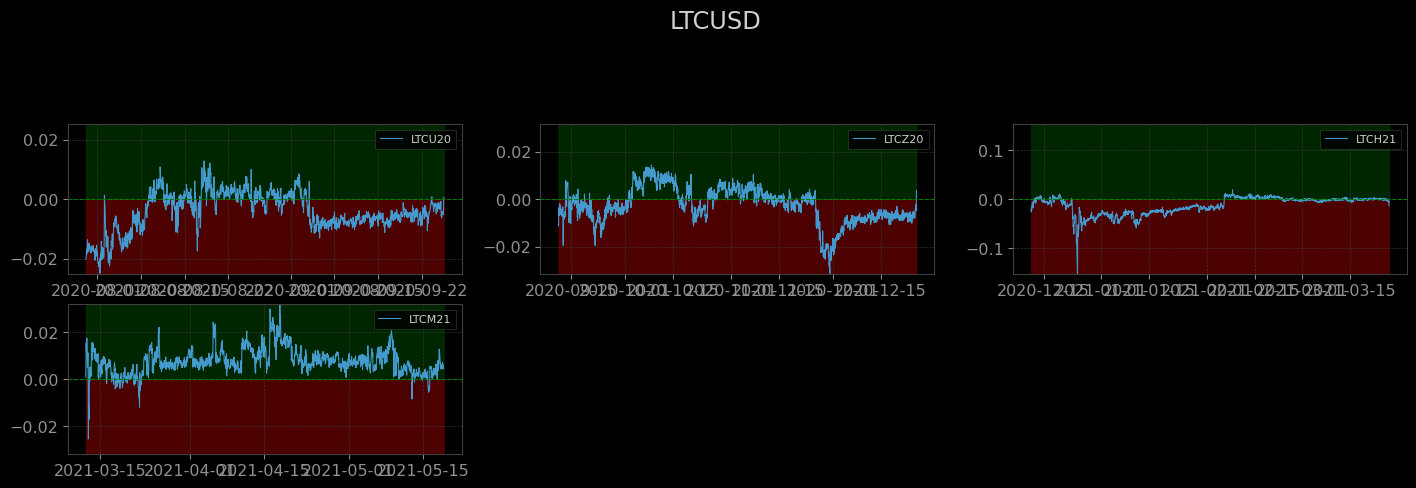

In [198]:
fig(18, 12); plot_statistics(d_ltc, spread_pct)

# <font color='yellow'>EOSUSD (percentage spread)</font>

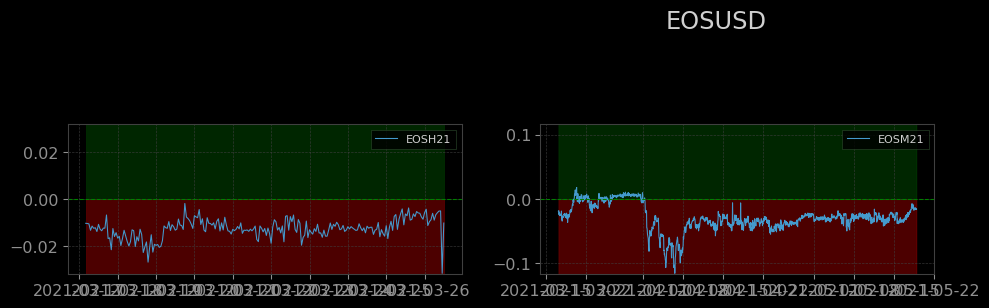

In [204]:
fig(18, 12); plot_statistics(d_eos, spread_pct)

# <font color='yellow'>XBTUSD (cumulative spread)</font>

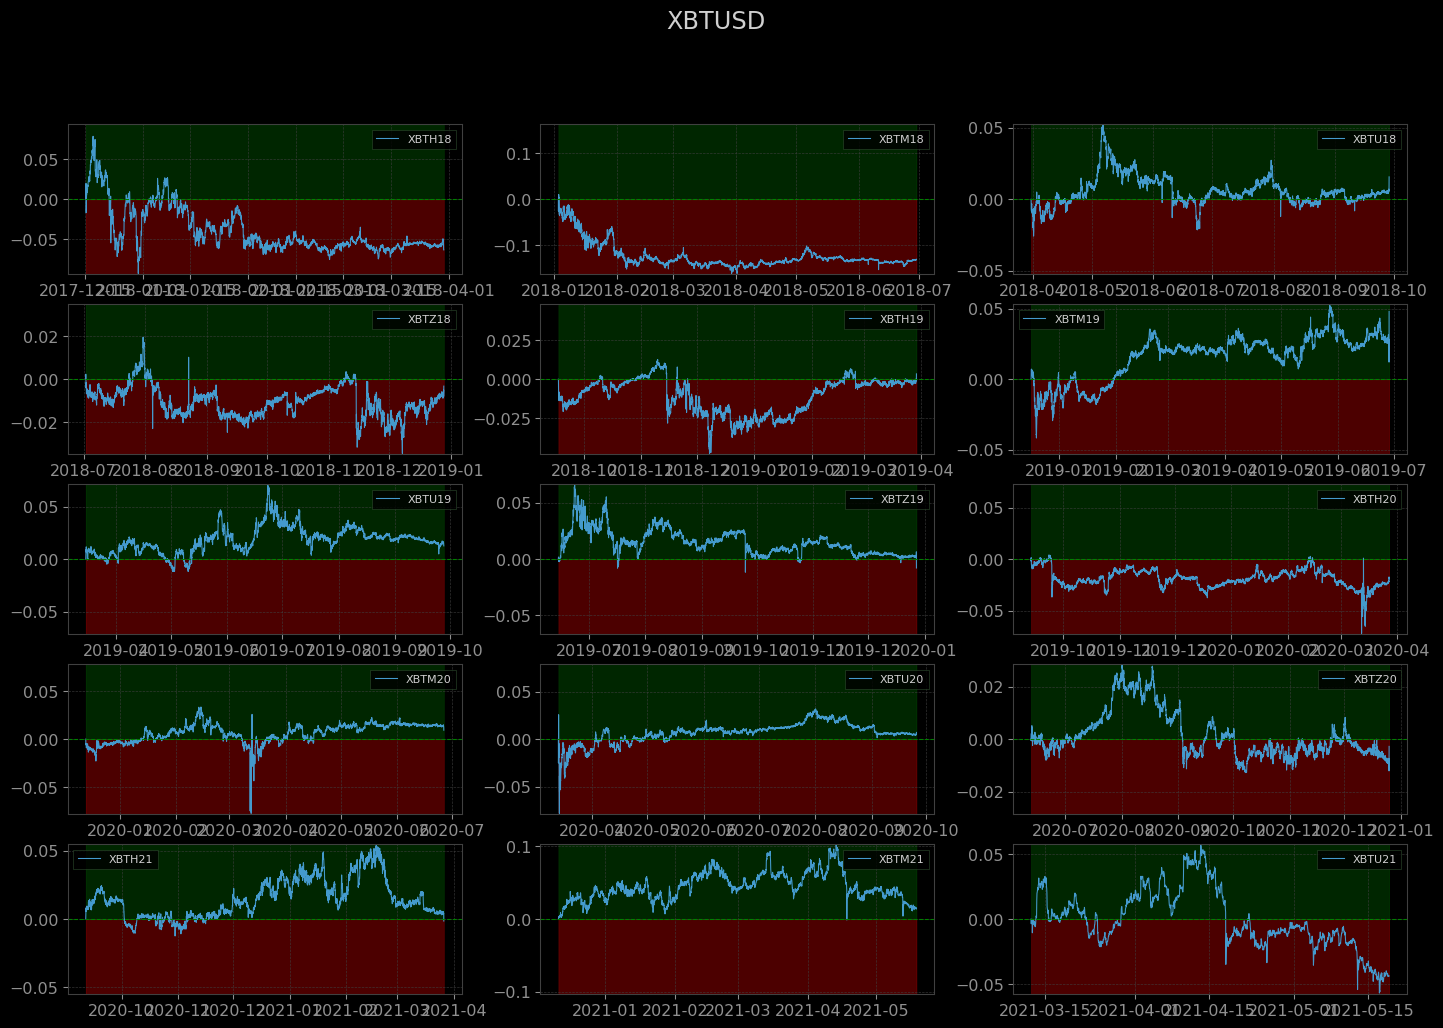

In [200]:
fig(18, 12); plot_statistics(d_xbt, spread_ret)

# <font color='yellow'>ETHUSD (cumulative spread)</font>

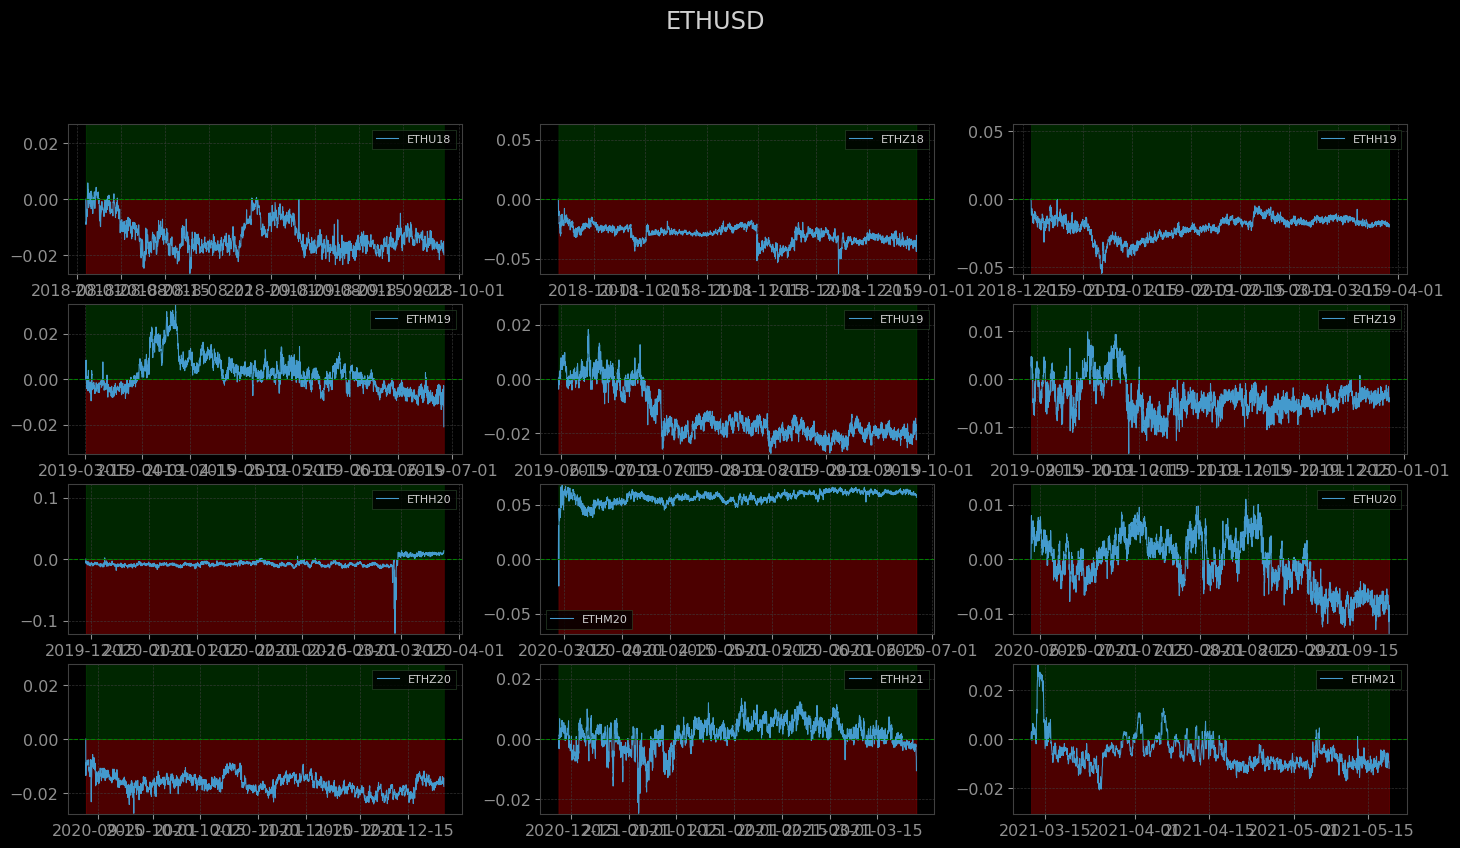

In [201]:
fig(18, 12); plot_statistics(d_eth, spread_ret)

# <font color='yellow'>LTCUSD (cumulative spread)</font>

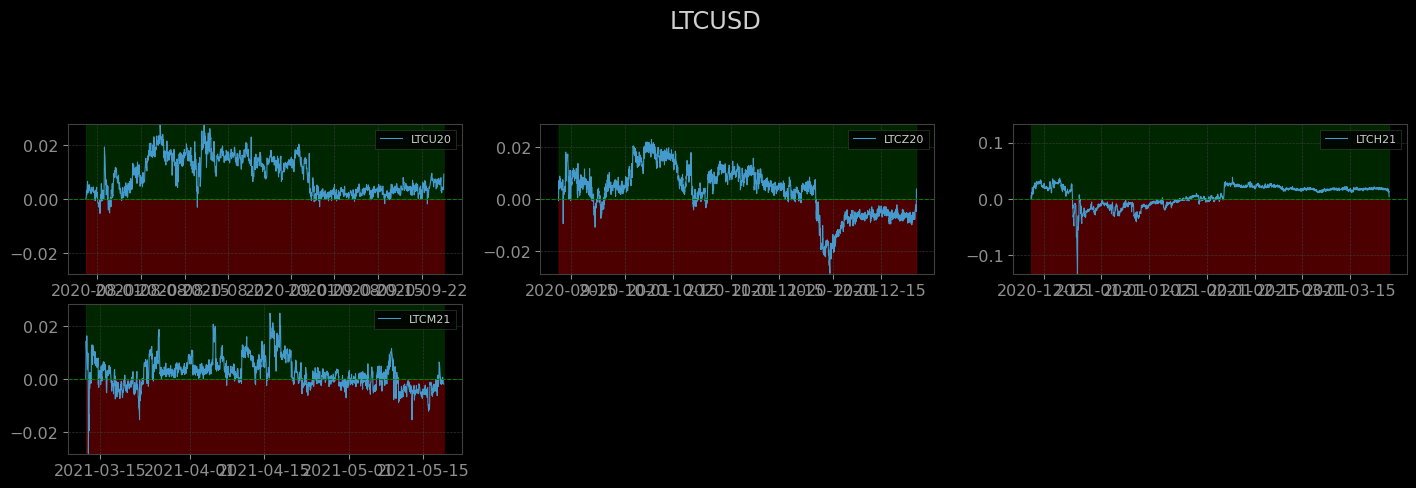

In [202]:
fig(18, 12); plot_statistics(d_ltc, spread_ret)

# <font color='yellow'>EOSUSD (cumulative spread)</font>

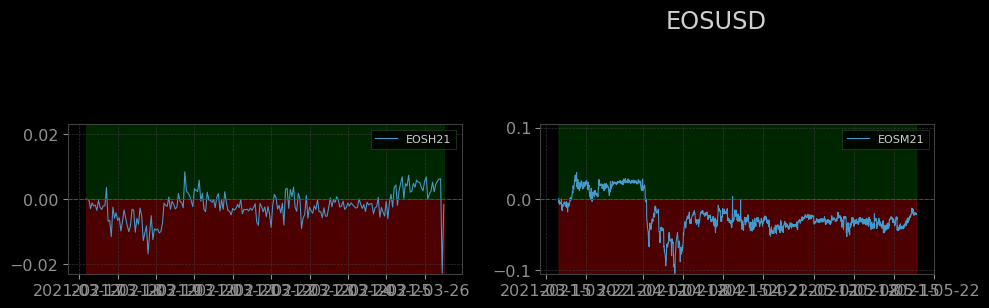

In [203]:
fig(18, 12); plot_statistics(d_eos, spread_ret)